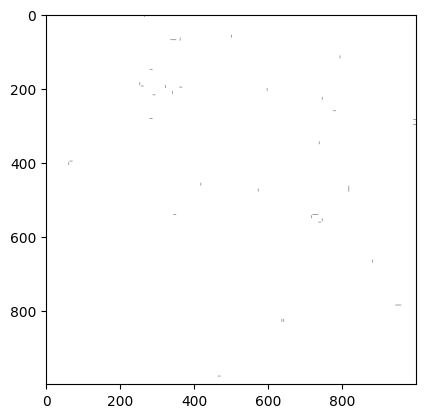

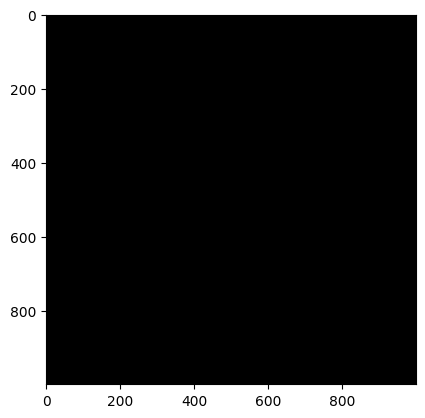

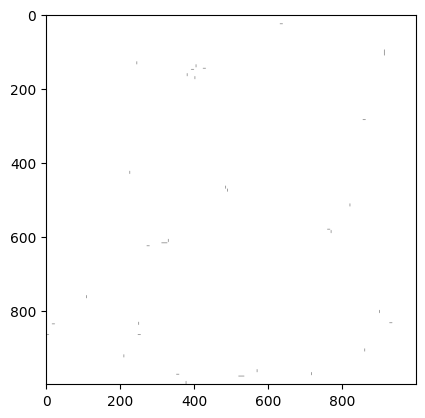

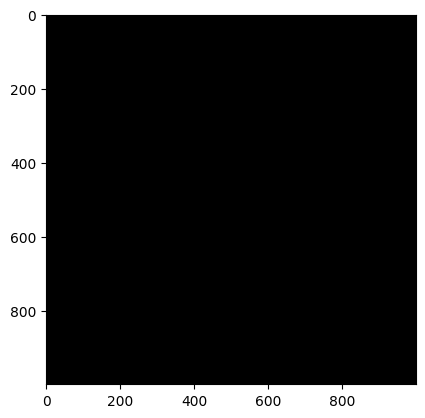

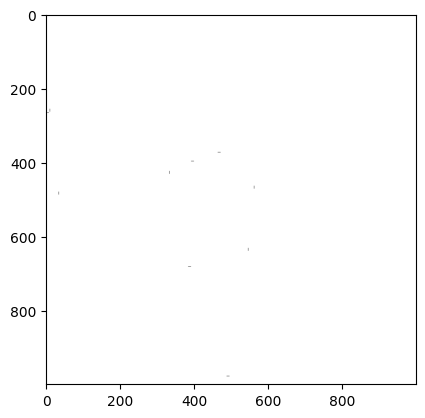

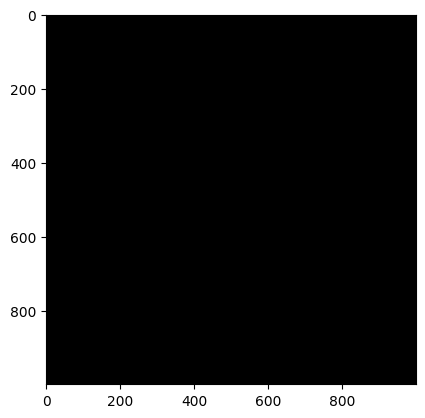

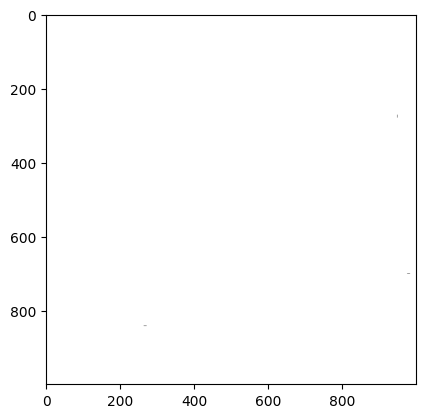

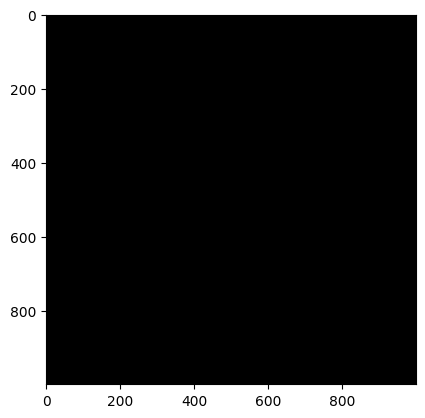

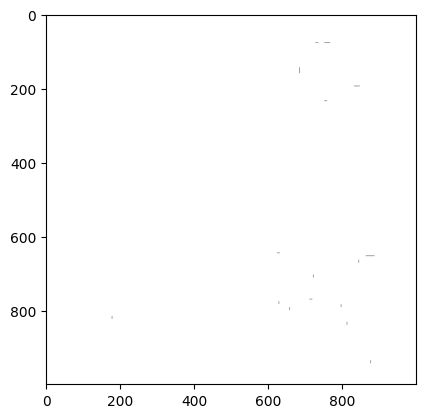

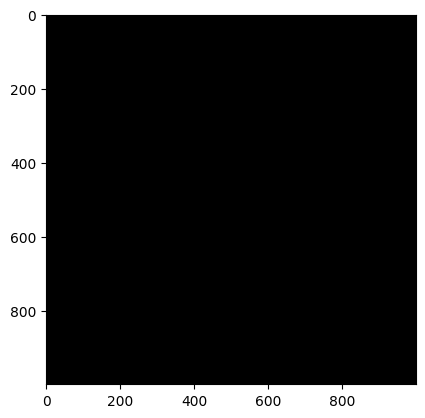

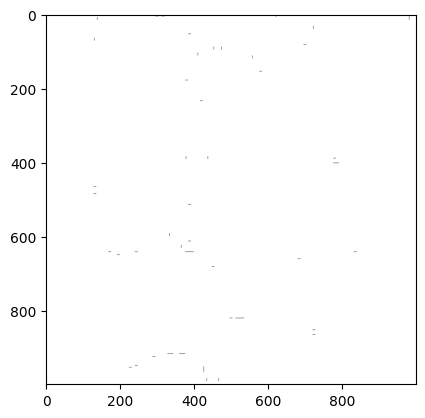

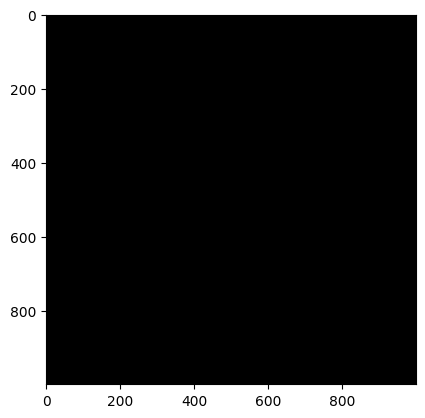

KeyboardInterrupt: 

In [11]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from scipy import ndimage as ndi

#AFTER ELASTIK SIMPLE SEGMENTATION

labels = ["dead", "keep2", "receed1", "split"]
for label in labels:
    path = os.path.join("D:/data_for_seg/z_projection/", label)
    files = os.listdir(path)
    files = [file for file in files if "Simple" in file]
    for file in files:
        image_path = os.path.join(path, file)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Failed to load image: {file}")
            continue
        
        
        # Make a copy of the image to create the final_image
        final_image = image.copy()

        # Pixels with value of 1 are set to 0
        final_image[image == 1] = 0

        # Pixels with values of 0, 2, or 3 are set to 255
        final_image[(image == 0) | (image == 2) | (image == 3)] = 255

        plt.imshow(final_image, cmap="gray")
        plt.show()

        final_image = ndi.binary_fill_holes(final_image).astype(int)

        plt.imshow(final_image, cmap="gray")
        plt.show()
        
        output_image_path = os.path.join(path, file)
        #cv2.imwrite(output_image_path, final_image)

In [35]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from scipy import ndimage as ndi
from skimage import morphology

#TRANSFORMATION AFTER FIRST ILASTIK TRANSFORMATION

labels = ["dead", "keep2", "receed1", "split"]
for label in labels:
    path = os.path.join("D:/data_for_seg/z_projection/", label)
    files = os.listdir(path)
    files = [file for file in files if "Simple" in file]
    for file in files:
        image_path = os.path.join(path, file)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Failed to load image: {file}")
            continue

        # Convert the image to binary if it's not already in binary form
        binary_image = image >= 255

        # Use remove_small_objects. You need to decide the 'min_size' threshold.
        # For example, if your objects are typically larger than 50 pixels, you can use that as a threshold.
        min_size = 200  # Define the minimum size of the object to keep
        cleaned_image = morphology.remove_small_objects(binary_image, min_size=min_size)

        # If you filled the holes before and want to do both operations, you can do it in sequence:
        filled_image = ndi.binary_fill_holes(cleaned_image).astype(int)

        # If you're going to write the image back, make sure it's in the correct format
        # Here, we convert it back to uint8 before saving
        output_image = (filled_image * 255).astype(np.uint8)  # Convert from binary to uint8
        
        # It's a good idea to save the output with a different name or in a different folder
        output_image_path = os.path.join(path, f"filled_{file}")
        cv2.imwrite(output_image_path, output_image)


In [8]:
import sys
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
from scipy import ndimage as ndi

import napari

from skimage.segmentation import watershed
from skimage.feature import peak_local_max

image_path = os.path.join(path, file)
image = cv2.imread("D:/data_for_seg/z_projection/dead/s06_Simple Segmentation.jpg", cv2.IMREAD_GRAYSCALE)
image = cv2.bitwise_not(image)
spacing = np.array([0.26, 0.26])

print(image.shape)

viewer = napari.view_image(
    image,
    scale=spacing,
    ndisplay=2,
)

(1000, 1000)


In [36]:
import cv2
import colors

labels = cv2.imread("D:/data_for_seg/z_projection/dead/filled_cleaned/labeled_filled_s06_no_stack_Simple Segmentation.tif")

label_cmap = colors.ListedColormap(np.random.rand(labels.max() + 1, 3))

# Create a colored label image
colored_label_image = label_cmap(labels)

# Convert to uint8 format (0-255)
colored_label_image = (colored_label_image * 255).astype(np.uint8)

plt.imshow(colored_label_image)
plt.show()

ModuleNotFoundError: No module named 'colors'

In [6]:
from skimage import filters

edges = filters.scharr(image)
viewer.add_image(
    edges,
    scale=spacing,
    blending='additive',
    colormap='magenta',
)

<Image layer 'edges' at 0x203979767d0>

In [69]:
denoised = ndi.median_filter(image, size=3)
li_thresholded = denoised > filters.threshold_li(denoised)
viewer.add_image(
    li_thresholded,
    scale=spacing,
    opacity=0.3,
)

<Image layer 'li_thresholded' at 0x22989e1a350>

In [70]:
from scipy import ndimage

li_thresholded = np.array([[not cell for cell in row] for row in li_thresholded])

li_thresholded = ndimage.binary_fill_holes(li_thresholded).astype(int)

viewer.add_image(
    li_thresholded,
    name='fill_holes',
    scale=spacing,
    opacity=0.3,
)

In [71]:
from skimage import morphology

width = 10

remove_holes = morphology.remove_small_holes(
    li_thresholded, width ** 3
)

width = 10

remove_objects = morphology.remove_small_objects(
    remove_holes, width ** 3
)

viewer.add_image(
    remove_objects,
    name='cleaned',
    scale=spacing,
    opacity=0.3,
)

viewer.layers['cleaned'].visible = False

C:\Users\laure\AppData\Local\Temp\ipykernel_47240\2358612619.py:5: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  remove_holes = morphology.remove_small_holes(


In [72]:
from skimage import measure

labels = measure.label(remove_objects)

viewer.add_labels(
    labels,
    scale=spacing,
    opacity=0.5,
)

viewer.layers['cleaned'].visible = False

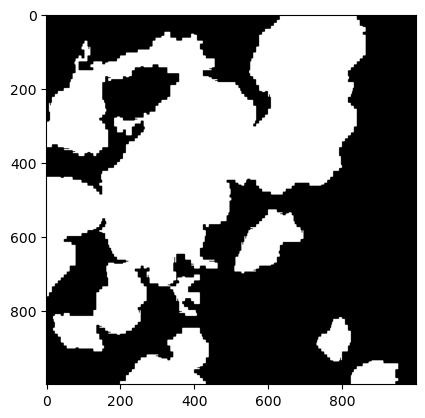

In [74]:
plt.imshow(remove_objects, cmap="gray")

In [87]:
import imutils

# find contours in the thresholded image
remove_objects = (remove_objects * 255).astype(np.uint8)
cnts = cv2.findContours(remove_objects.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
print("[INFO] {} unique contours found".format(len(cnts)))
# loop over the contours
for (i, c) in enumerate(cnts):
	# draw the contour
	((x, y), _) = cv2.minEnclosingCircle(c)
	cv2.putText(image, "#{}".format(i + 1), (int(x) - 10, int(y)),
		cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
	cv2.drawContours(image, [c], -1, (0, 255, 0), 2)
# show the output image
cv2.imshow("Image", image)
cv2.waitKey(0)

[INFO] 5 unique contours found


error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1272: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


In [95]:
# import the necessary packages
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage
import numpy as np
import argparse
import imutils
import cv2

thresh = remove_objects
# compute the exact Euclidean distance from every binary
# pixel to the nearest zero pixel, then find peaks in this
# distance map
D = ndimage.distance_transform_edt(thresh)
localMax = peak_local_max(D, min_distance=20,
	labels=thresh)
# perform a connected component analysis on the local peaks,
# using 8-connectivity, then appy the Watershed algorithm
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=thresh)
print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))

ValueError: operands could not be broadcast together with shapes (31,2) (1000,1000) 